In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

set_label = ['50-25','75-37','100-50','125-67','150-75']
set_A_05 = ['0121_0157', '0121_0204', '0121_0211', '0121_0219', '0121_0227']
set_B_02 = ['0104_2223', '0104_2309', '0104_2328', '0104_2343', '0105_0013']
set_C_10 = ['0116_0117', '0116_0125', '0116_0132', '0116_0140', '0116_0149']
set_D_06 = ['0104_1949', '0104_2002', '0104_2016', '0104_2032', '0104_2056']

selected_set = set_B_02

In [2]:
car_df = pd.DataFrame(columns=['dist', 'mesh', 'bbox_size', 'frame_id'])
truck_df = pd.DataFrame(columns=['dist', 'mesh', 'bbox_size', 'frame_id'])
van_df = pd.DataFrame(columns=['dist', 'mesh', 'bbox_size', 'frame_id'])

for i in range(len(selected_set)):
    time_dirc = selected_set[i]
    sem_pt_path = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_'+time_dirc+'/vehicle.tesla.model3.master/velodyne_semantic/'
    file_list = os.listdir(sem_pt_path)
    file_list = [f for f in file_list if f.endswith('.txt')]
    file_list.sort()

    for file in file_list:
        with open(sem_pt_path+file) as f:
            lines = f.readlines()[:-1]

            for line in lines:
                line = line.strip().split()
                if line[7] == 'Car':
                    cy, cz, cx = np.float64(line[0]), np.float64(line[1]), np.float64(line[2])
                    sy, sx ,sz = np.float64(line[3]), np.float64(line[4]), np.float64(line[5])
                    dist = np.sqrt(cx**2 + cy**2 + (cz-0.5*sz)**2)
                    if dist < 60:
                        mesh = min(2000, np.float64(line[8]))
                        bbox_size = np.sqrt(sx**2 + sy**2 + sz**2)
                        new_row = pd.Series({'dist': dist, 'mesh': mesh, 'bbox_size': bbox_size, 'frame_id': int(str(i)+file[-9:-4])})
                        car_df = pd.concat([car_df, new_row.to_frame().T], ignore_index=True)
                elif line[7] == 'Truck':
                    cy, cz, cx = np.float64(line[0]), np.float64(line[1]), np.float64(line[2])
                    sy, sx ,sz = np.float64(line[3]), np.float64(line[4]), np.float64(line[5])
                    dist = np.sqrt(cx**2 + cy**2 + (cz-0.5*sz)**2)
                    if dist < 60:
                        mesh = min(2000, np.float64(line[8]))
                        bbox_size = np.sqrt(sx**2 + sy**2 + sz**2)
                        new_row = pd.Series({'dist': dist, 'mesh': mesh, 'bbox_size': bbox_size, 'frame_id': int(str(i)+file[-9:-4])})
                        truck_df = pd.concat([truck_df, new_row.to_frame().T], ignore_index=True)
                elif line[7] == 'Van':
                    cy, cz, cx = np.float64(line[0]), np.float64(line[1]), np.float64(line[2])
                    sy, sx ,sz = np.float64(line[3]), np.float64(line[4]), np.float64(line[5])
                    dist = np.sqrt(cx**2 + cy**2 + (cz-0.5*sz)**2)
                    if dist< 60:
                        mesh = min(2000, np.float64(line[8]))
                        bbox_size = np.sqrt(sx**2 + sy**2 + sz**2)
                        new_row = pd.Series({'dist': dist, 'mesh': mesh, 'bbox_size': bbox_size, 'frame_id': int(str(i)+file[-9:-4])})
                        van_df = pd.concat([van_df, new_row.to_frame().T], ignore_index=True)



In [3]:
car_df.head()

,dist,mesh,bbox_size,frame_id
0,54.854212,50.0,5.817201,19898.0
1,51.760444,148.0,5.817201,19901.0
2,48.864307,184.0,5.817201,19904.0
3,45.930213,218.0,5.817201,19907.0
4,42.986280,182.0,5.817201,19910.0


In [4]:
PF_ALPHA = 1.5
PF_K = 1.0
PF_D = 1E5
PF_H = 0.5
PF_RANGE = 60

def function_a(dist, mesh):
    score = dist**2 * mesh / (dist *np.log(dist))
    # score = np.where(score > 30000, 30000, score)
    return score

def function_b(dist, mesh):
    l = dist / PF_RANGE
    score = (dist**2 * mesh) / (PF_D * (l * np.log(l)+ PF_H))
    # score = np.where(score > 65, 0, score)
    return score

def function_c(dist, mesh, bbox_size):
    l = dist / PF_RANGE
    score = (dist**2 * mesh / bbox_size) / (PF_D * (l * np.log(l)+ PF_H))
    # score = np.where(score > 25, 0, score)
    return score

def function_d(dist, mesh, bbox_size):
    l = dist / PF_RANGE
    score = (dist**2 * mesh / (bbox_size*np.sqrt(bbox_size))) / (PF_D * (l * np.log(l)+ PF_H))
    return score

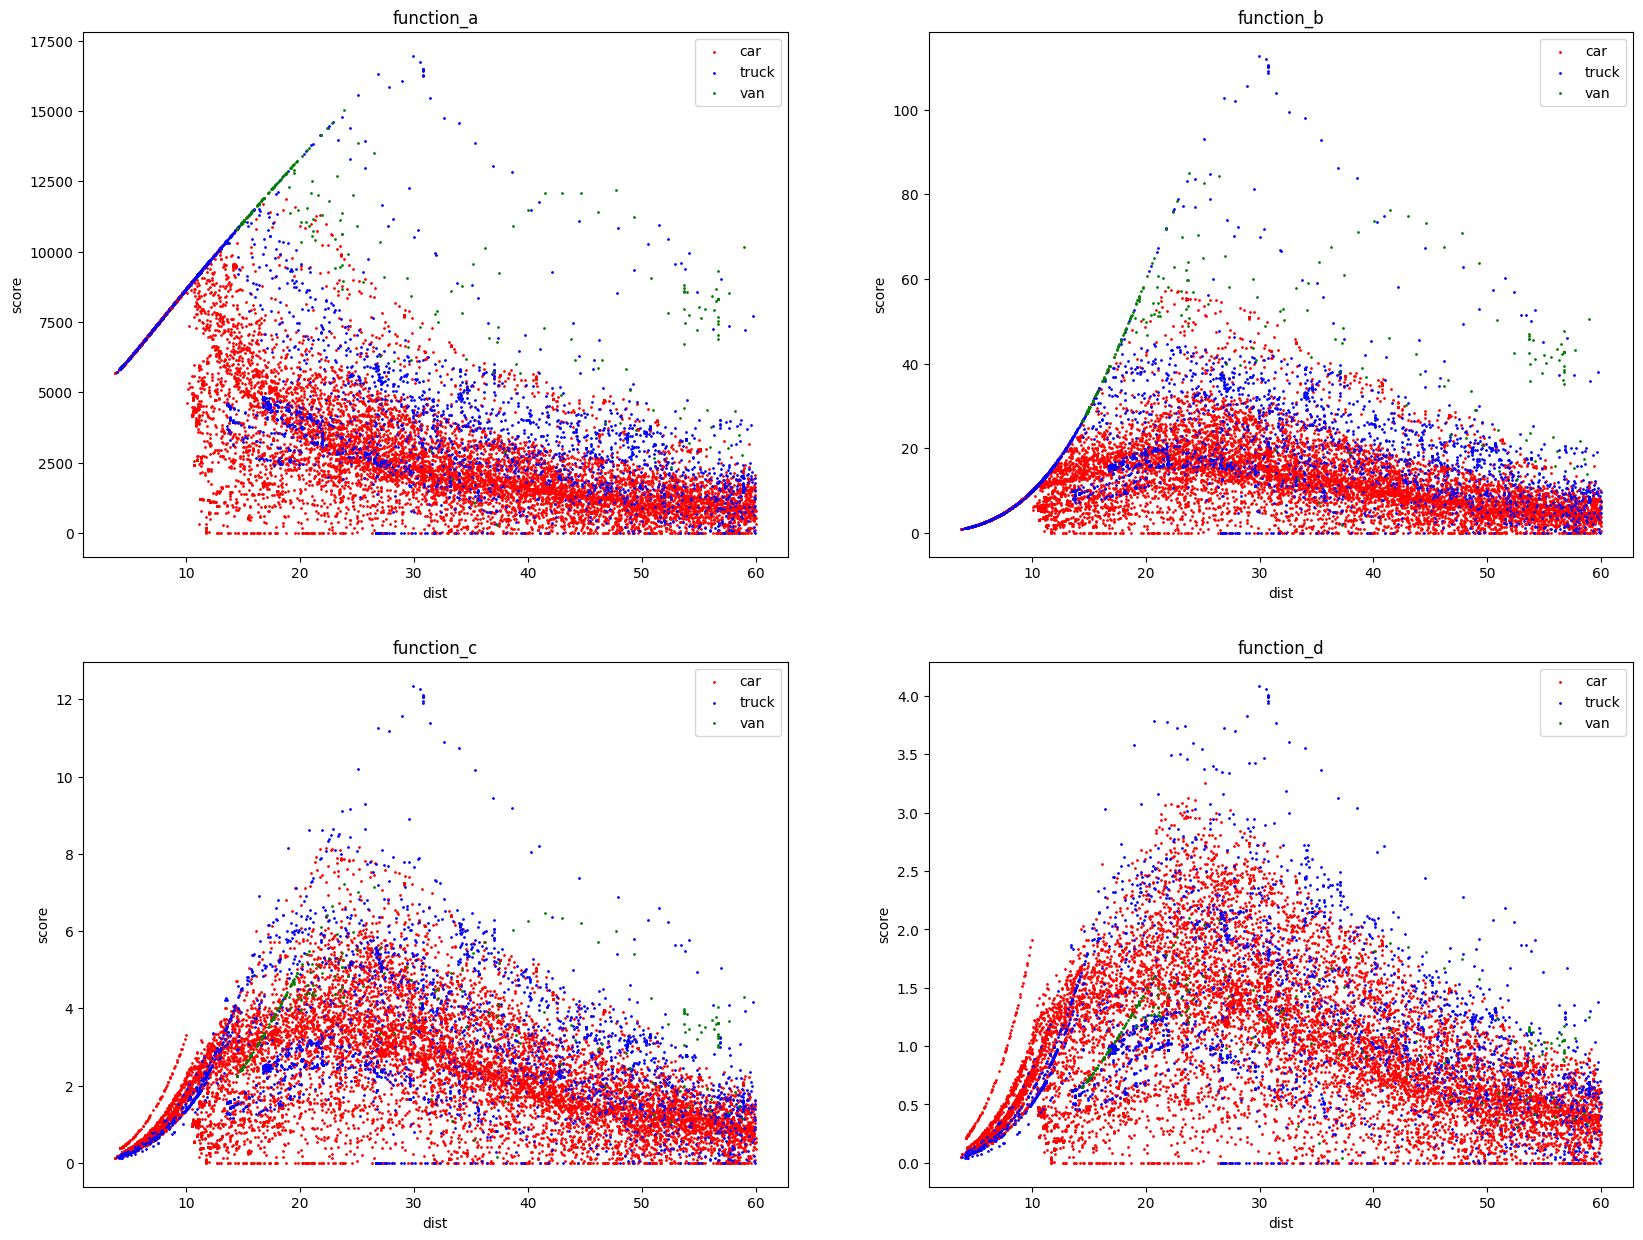

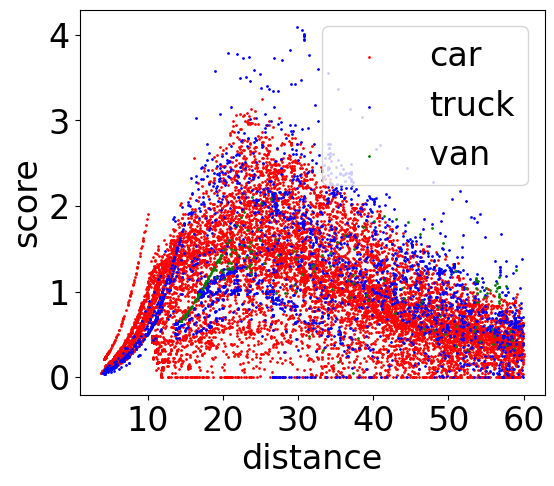

In [5]:
car_score_a = function_a(car_df['dist'], car_df['mesh'])
truck_score_a = function_a(truck_df['dist'], truck_df['mesh'])
van_score_a = function_a(van_df['dist'], van_df['mesh'])

car_score_b = function_b(car_df['dist'], car_df['mesh'])
truck_score_b = function_b(truck_df['dist'], truck_df['mesh'])
van_score_b = function_b(van_df['dist'], van_df['mesh'])

car_score_c = function_c(car_df['dist'], car_df['mesh'], car_df['bbox_size'])
truck_score_c = function_c(truck_df['dist'], truck_df['mesh'], truck_df['bbox_size'])
van_score_c = function_c(van_df['dist'], van_df['mesh'], van_df['bbox_size'])

car_score_d = function_d(car_df['dist'], car_df['mesh'], car_df['bbox_size'])
truck_score_d = function_d(truck_df['dist'], truck_df['mesh'], truck_df['bbox_size'])
van_score_d = function_d(van_df['dist'], van_df['mesh'], van_df['bbox_size'])

# visualize
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

ax1.scatter(car_df['dist'], car_score_a, s=1, c='r', label='car')
ax1.scatter(truck_df['dist'], truck_score_a, s=1, c='b', label='truck')
ax1.scatter(van_df['dist'], van_score_a, s=1, c='g', label='van')
ax1.set_xlabel('dist')
ax1.set_ylabel('score')
ax1.legend()
ax1.set_title('function_a')
ax2.scatter(car_df['dist'], car_score_b, s=1, c='r', label='car')
ax2.scatter(truck_df['dist'], truck_score_b, s=1, c='b', label='truck')
ax2.scatter(van_df['dist'], van_score_b, s=1, c='g', label='van')
ax2.set_xlabel('dist')
ax2.set_ylabel('score')
ax2.legend()
ax2.set_title('function_b')
ax3.scatter(car_df['dist'], car_score_c, s=1, c='r', label='car')
ax3.scatter(truck_df['dist'], truck_score_c, s=1, c='b', label='truck')
ax3.scatter(van_df['dist'], van_score_c, s=1, c='g', label='van')
ax3.set_xlabel('dist')
ax3.set_ylabel('score')
ax3.legend()
ax3.set_title('function_c')
ax4.scatter(car_df['dist'], car_score_d, s=1, c='r', label='car')
ax4.scatter(truck_df['dist'], truck_score_d, s=1, c='b', label='truck')
ax4.scatter(van_df['dist'], van_score_d, s=1, c='g', label='van')
ax4.set_xlabel('dist')
ax4.set_ylabel('score')
ax4.legend()
ax4.set_title('function_d')

plt.show()



fig = plt.figure(figsize=(6, 5))
plt.scatter(car_df['dist'], car_score_d, s=1, c='r', label='car')
plt.scatter(truck_df['dist'], truck_score_d, s=1, c='b', label='truck')
plt.scatter(van_df['dist'], van_score_d, s=1, c='g', label='van')
plt.xlabel('distance',fontsize=24)
plt.ylabel('score',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.locator_params(nbins=8)
plt.savefig('s2_func_fig6.pdf')
plt.show()


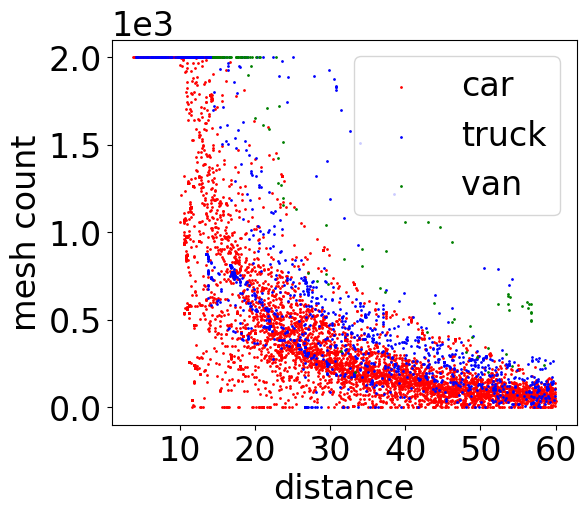

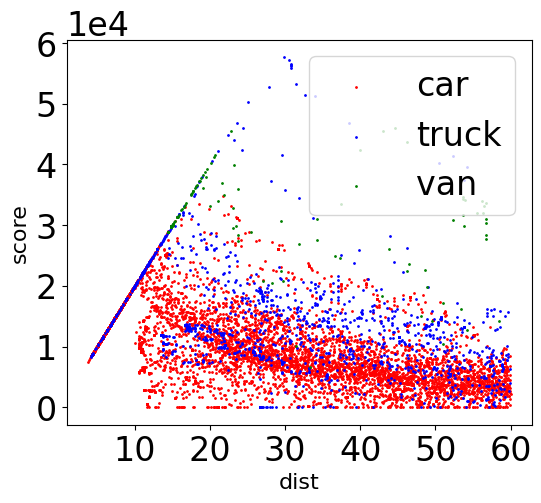

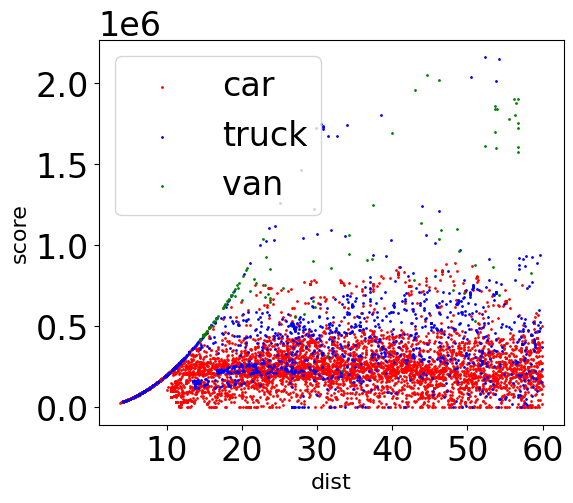

In [9]:
import random
spilt = 0.5


split = 0.5

# Randomly select a percentage of samples
car_df_sampled = car_df.sample(frac=split, random_state=42)
truck_df_sampled = truck_df.sample(frac=split, random_state=42)
van_df_sampled = van_df.sample(frac=split, random_state=42)

# randomly select a percentage of samples
car_score_d_sampled = pd.Series(car_score_d).sample(frac=split, random_state=42)
truck_score_d_sampled = pd.Series(truck_score_d).sample(frac=split, random_state=42)
van_score_d_sampled = pd.Series(van_score_d).sample(frac=split, random_state=42)

# fig = plt.figure(figsize=(6, 5))
# ax = fig.add_subplot(111, projection='3d')
# # show in 3d, x = dist, y = mesh, z = score
# ax.scatter(car_df_sampled['dist'], car_df_sampled['mesh'], car_score_d_sampled, c='r', s=1, label='car')
# ax.scatter(truck_df_sampled['dist'], truck_df_sampled['mesh'], truck_score_d_sampled, c='b', s=1, label='truck')
# ax.scatter(van_df_sampled['dist'], van_df_sampled['mesh'], van_score_d_sampled, c='g', s=1, label='van')
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xlabel('dist',fontsize=16)
# ax.set_ylabel('mesh count',fontsize=16)
# ax.set_zlabel('score',fontsize=16)
# ax.legend(fontsize=14, loc='center left')
# ax.invert_xaxis()
# plt.rcParams.update({'font.size': 14})
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# plt.savefig('s2_func_fig4.pdf')

fig1, ax1 = plt.subplots(figsize=(6, 5))
plt.rcParams.update({'font.size': 24})
ax1.scatter(car_df_sampled['dist'], car_df_sampled['mesh'], c='r', s=1, label='car')
ax1.scatter(truck_df_sampled['dist'], truck_df_sampled['mesh'],  c='b', s=1, label='truck')
ax1.scatter(van_df_sampled['dist'], van_df_sampled['mesh'],  c='g', s=1, label='van')
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.set_xlabel('distance',fontsize=24)
ax1.set_ylabel('mesh count',fontsize=24)
ax1.legend(fontsize=24)
plt.rcParams.update({'font.size': 24})
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.locator_params(nbins=8)
plt.savefig('s2_func_fig1.pdf')

fig2, ax2 = plt.subplots(figsize=(6, 5))
ax2.scatter(car_df_sampled['dist'], car_df_sampled['mesh']*car_df_sampled['dist'],  c='r', s=1, label='car')
ax2.scatter(truck_df_sampled['dist'], truck_df_sampled['mesh']*truck_df_sampled['dist'],  c='b', s=1, label='truck')
ax2.scatter(van_df_sampled['dist'], van_df_sampled['mesh']*van_df_sampled['dist'],  c='g', s=1, label='van')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('dist',fontsize=16)
ax2.set_ylabel('score',fontsize=16)
ax2.legend(fontsize=14)
plt.rcParams.update({'font.size': 24})
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.locator_params(nbins=8)
plt.savefig('s2_func_fig2.pdf')

fig3, ax3 = plt.subplots(figsize=(6, 5))
ax3.scatter(car_df_sampled['dist'], car_df_sampled['mesh']*car_df_sampled['dist']**2, c='r', s=1, label='car')
ax3.scatter(truck_df_sampled['dist'], truck_df_sampled['mesh']*truck_df_sampled['dist']**2,  c='b', s=1, label='truck')
ax3.scatter(van_df_sampled['dist'], van_df_sampled['mesh']*van_df_sampled['dist']**2,  c='g', s=1, label='van')
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_xlabel('dist',fontsize=16)
ax3.set_ylabel('score',fontsize=16)
ax3.legend(fontsize=14)
plt.rcParams.update({'font.size': 24})
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.locator_params(nbins=8)
plt.savefig('s2_func_fig3.pdf')

# draw 3d plot




# fig4, ax4 = plt.subplots(figsize=(6, 5), subplot_kw={'projection': '3d'})
# # show in 3d, x = dist, y = mesh, z = dist*mesh**2
# ax4.scatter(car_df_sampled['dist'], car_df_sampled['mesh'], car_score_d_sampled, c='r', s=1, label='car')
# ax4.scatter(truck_df_sampled['dist'], truck_df_sampled['mesh'], truck_score_d_sampled, c='b', s=1, label='truck')
# ax4.scatter(van_df_sampled['dist'], van_df_sampled['mesh'], van_score_d_sampled, c='g', s=1, label='van')
# ax4.tick_params(axis='both', which='major', labelsize=14)
# ax4.set_xlabel('dist',fontsize=16)
# ax4.set_ylabel('mesh count',fontsize=16)
# ax4.set_zlabel('score',fontsize=16)
# ax4.legend(fontsize=14)
# ax4.invert_xaxis()
# plt.rcParams.update({'font.size': 14})
# ax4.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# plt.savefig('s2_func_fig4.pdf')

plt.show()

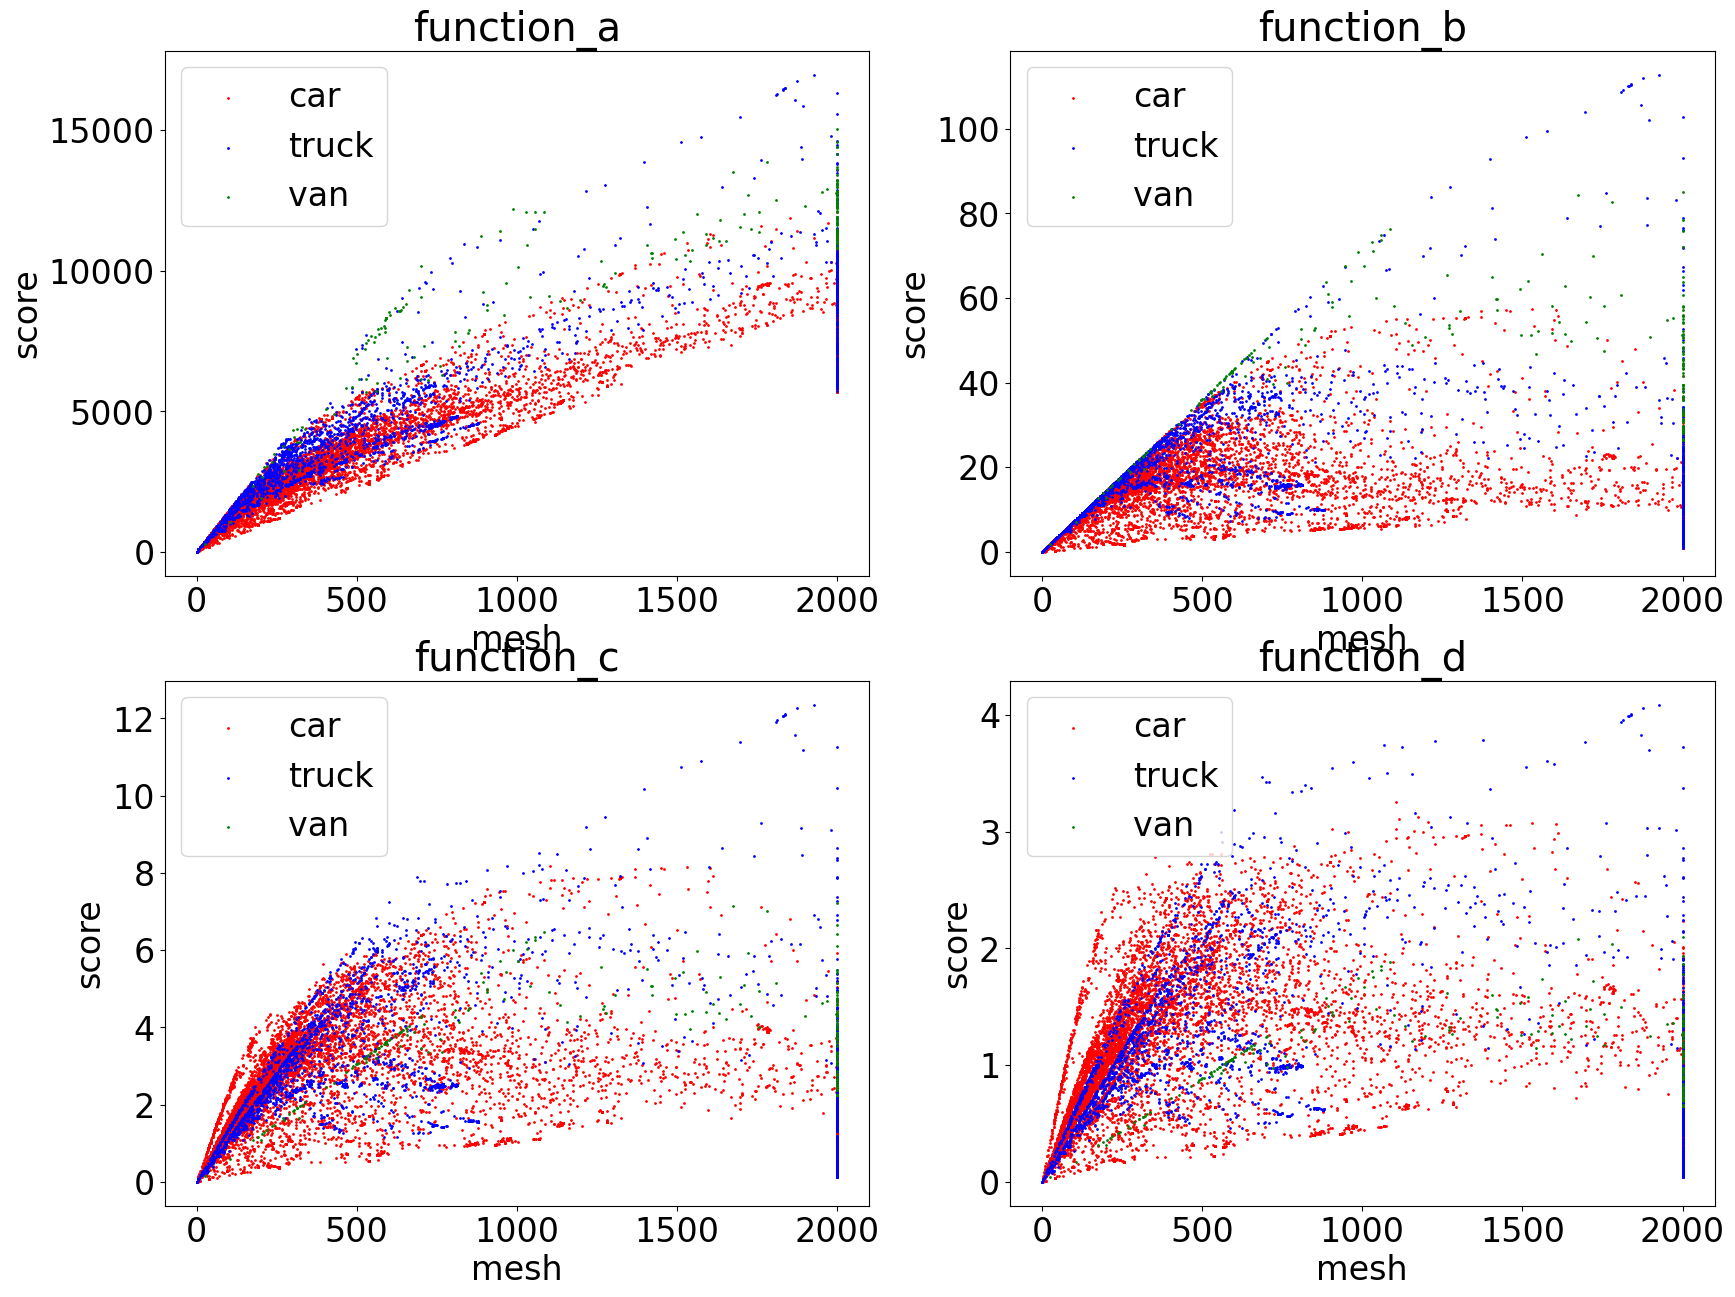

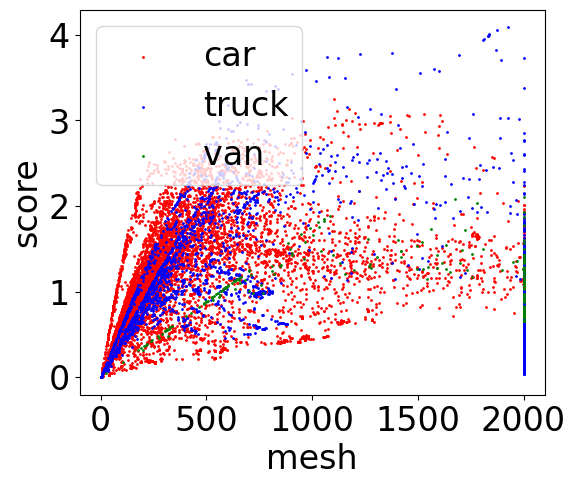

In [12]:
# visualize
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

ax1.scatter(car_df['mesh'], car_score_a, s=1, c='r', label='car')
ax1.scatter(truck_df['mesh'], truck_score_a, s=1, c='b', label='truck')
ax1.scatter(van_df['mesh'], van_score_a, s=1, c='g', label='van')
ax1.set_xlabel('mesh')
ax1.set_ylabel('score')
ax1.legend()
ax1.set_title('function_a')
ax2.scatter(car_df['mesh'], car_score_b, s=1, c='r', label='car')
ax2.scatter(truck_df['mesh'], truck_score_b, s=1, c='b', label='truck')
ax2.scatter(van_df['mesh'], van_score_b, s=1, c='g', label='van')
ax2.set_xlabel('mesh')
ax2.set_ylabel('score')
ax2.legend()
ax2.set_title('function_b')
ax3.scatter(car_df['mesh'], car_score_c, s=1, c='r', label='car')
ax3.scatter(truck_df['mesh'], truck_score_c, s=1, c='b', label='truck')
ax3.scatter(van_df['mesh'], van_score_c, s=1, c='g', label='van')
ax3.set_xlabel('mesh')
ax3.set_ylabel('score')
ax3.legend()
ax3.set_title('function_c')
ax4.scatter(car_df['mesh'], car_score_d, s=1, c='r', label='car')
ax4.scatter(truck_df['mesh'], truck_score_d, s=1, c='b', label='truck')
ax4.scatter(van_df['mesh'], van_score_d, s=1, c='g', label='van')
ax4.set_xlabel('mesh')
ax4.set_ylabel('score')
ax4.legend()
ax4.set_title('function_d')

plt.show()

fig = plt.figure(figsize=(6, 5))
plt.scatter(car_df['mesh'], car_score_d, s=1, c='r', label='car')
plt.scatter(truck_df['mesh'], truck_score_d, s=1, c='b', label='truck')
plt.scatter(van_df['mesh'], van_score_d, s=1, c='g', label='van')
plt.xlabel('mesh',fontsize=24)
plt.ylabel('score',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.legend(fontsize=24, loc='upper left')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.locator_params(nbins=8)
plt.savefig('s2_func_fig5.pdf')
plt.show()


(4184, 4) (2243, 4) (332, 4)
(4184, 2)


/tmp/ipykernel_8349/303223004.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vehicle_df['score'])


<AxesSubplot:xlabel='score', ylabel='Density'>

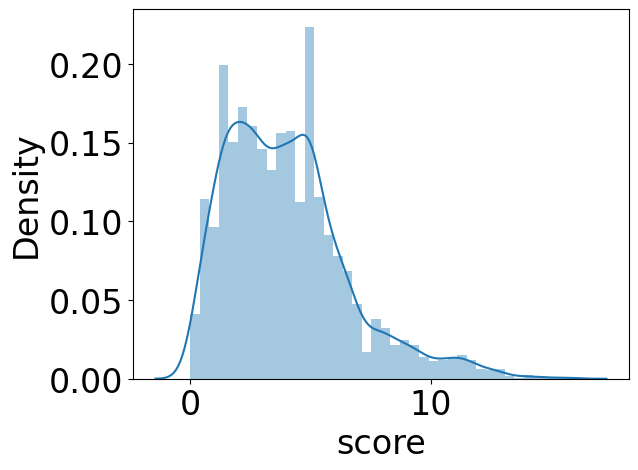

In [8]:
import seaborn as sns
car_df['score'] = car_score_d
truck_df['score'] = truck_score_d
van_df['score'] = van_score_d

car_df3 = car_df.groupby('frame_id').sum()
truck_df3 = truck_df.groupby('frame_id').sum()
van_df3 = van_df.groupby('frame_id').sum()

print(car_df3.shape, truck_df3.shape, van_df3.shape)

# sum three types vehicle score by frame id, save frame id and score at a new dataframe
vehicle_df = pd.DataFrame(columns=['frame_id', 'score'])
for frame_id in car_df3.index:
    # get score use index
    car_score = car_df3.loc[frame_id]['score']
    if frame_id in truck_df3.index:
        truck_score = truck_df3.loc[frame_id]['score']
    else:
        truck_score = 0

    if frame_id in van_df3.index:
        van_score = van_df3.loc[frame_id]['score']
    else:
        van_score = 0

    score = car_score + truck_score + van_score
    
    new_row = pd.Series({'frame_id': frame_id, 'score': score})
    vehicle_df = pd.concat([vehicle_df, new_row.to_frame().T], ignore_index=True)

print(vehicle_df.shape)
sns.distplot(vehicle_df['score'])